In [1]:
import numpy as np
from utils import *
from full_model import PseTae
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
ROOT_DIR = "timematch_data"
SOURCE_DIR = "denmark/32VNH/2017"
TARGET_DIR = "timematch_data/denmark/32VNH/2017"
OUTPUT_DIR = "/content/outputs"
NUM_FOLDS = 5
EPOCHS = 100

In [3]:
classes = get_classes("denmark")
dataset = PixelSetData(ROOT_DIR, SOURCE_DIR, classes, with_extra=False)
print(len(dataset))
print(len(classes))
print(dataset[0].keys())
print(dataset[0])

4996
17
dict_keys(['index', 'parcel_index', 'pixels', 'valid_pixels', 'positions', 'extra', 'label'])
{'index': 0, 'parcel_index': 0, 'pixels': array([[[1749, 1726, 1807, ..., 1839, 1856, 1889],
        [1214, 1188, 1201, ..., 1283, 1300, 1318],
        [1185, 1160, 1169, ..., 1333, 1290, 1315],
        ...,
        [2196, 2141, 2056, ..., 1962, 2046, 1954],
        [1396, 1394, 1276, ..., 1022, 1050,  970],
        [ 859,  855,  816, ...,  682,  708,  658]],

       [[1193, 1178, 1198, ..., 3014, 3054, 3096],
        [ 812,  810,  803, ..., 2564, 2554, 2646],
        [ 659,  676,  681, ..., 2638, 2714, 2820],
        ...,
        [1013,  994, 1039, ..., 3245, 3232, 3312],
        [ 887,  893,  905, ..., 2628, 2650, 2726],
        [ 528,  534,  550, ..., 2021, 2034, 2096]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0

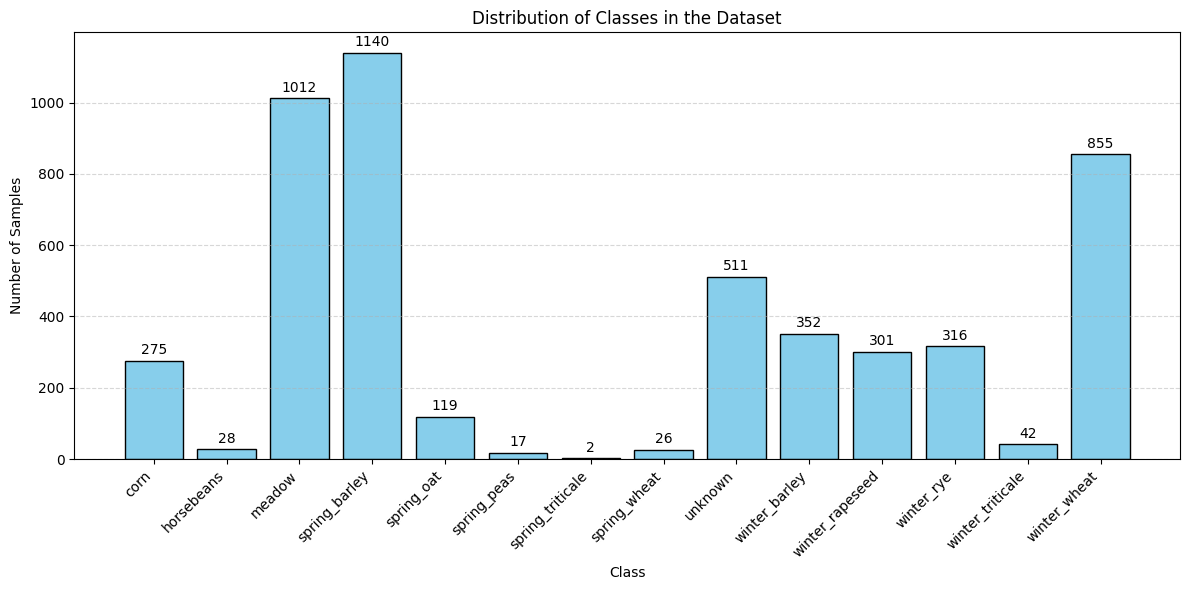

In [4]:
labels, counts = np.unique(dataset.get_labels(), return_counts=True)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
label_names = [idx_to_class[lbl] for lbl in labels]
plot_distribution(label_names, counts, save_path="figures/init_distr")


Keeping 8 classes out of 14 total.
4762


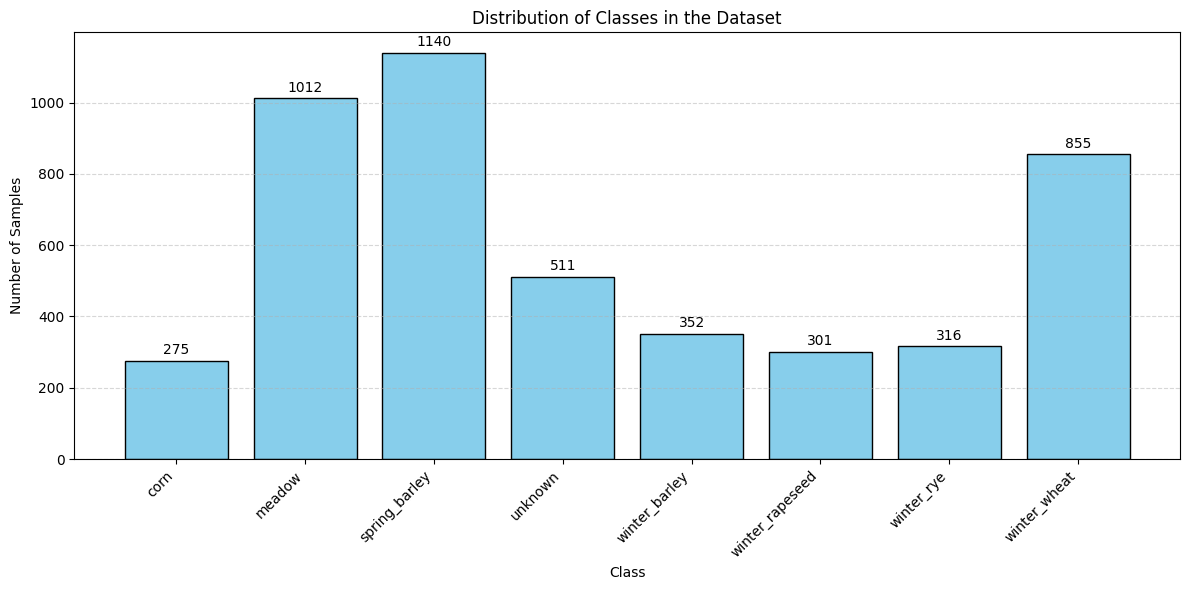

In [5]:
valid_labels = labels[counts >= 200]

print(f"Keeping {len(valid_labels)} classes out of {len(labels)} total.")

label_remap = {old: new for new, old in enumerate(valid_labels)}

idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
new_class_names = {label_remap[old]: idx_to_class[old] for old in valid_labels}

# filter and samples
filtered_samples = []
filtered_idxs = []
for sample in dataset.samples:
    path, parcel_idx, y, extra = sample
    if y in valid_labels:
        new_y = label_remap[y]
        filtered_samples.append((path, parcel_idx, new_y, extra))
        filtered_idxs.append(parcel_idx)

dataset.samples = filtered_samples
dataset.class_to_idx = {name: new_idx for new_idx, name in new_class_names.items()}

labels, counts = np.unique([s[2] for s in dataset.samples], return_counts=True)
label_names = [new_class_names[lbl] for lbl in labels]
print(len(dataset))
plot_distribution(label_names, counts, "figures/filtered_distr")

In [6]:
filtered_dataset = PixelSetData(ROOT_DIR, SOURCE_DIR, list(new_class_names.values()), with_extra=True, indices=filtered_idxs)

In [7]:
cv_loaders = get_dataloaders_for_cv(filtered_dataset, n_splits=5, sample_pixels=32, batch_size=128)

In [8]:
training_folds_stats = []
for i, (train_dl, _) in enumerate(cv_loaders):
    print(f"Computing per channel mean and std of the training data for fold {i}")
    means, stds = compute_band_stats_from_dl(train_dl)
    training_folds_stats.append((means, stds))

Computing per channel mean and std of the training data for fold 0
Computing per channel mean and std of the training data for fold 1
Computing per channel mean and std of the training data for fold 2
Computing per channel mean and std of the training data for fold 3
Computing per channel mean and std of the training data for fold 4


In [9]:
model = PseTae(num_classes=len(new_class_names.values()))
model.param_ratio()

TOTAL TRAINABLE PARAMETERS : 163400
RATIOS: Spatial  12.1% , Temporal  81.4% , Classifier   6.5%


163400

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [11]:
per_phase_accs, per_phase_macro_pres, per_phase_macro_rec, per_phase_macro_f1 = [], [], [], [],
per_phase_weighted_pres, per_phase_weighted_rec, per_phase_weighted_f1, best_epochs = [], [], [], [0, 0, 0, 0, 0]

for phase_idx, (train_dl, val_dl) in enumerate(cv_loaders):
    all_accs, all_macro_pres, all_macro_rec, all_macro_f1, all_weighted_pres, all_weighted_rec, all_weighted_f1 = [], [], [], [], [], [], []
    per_channel_means, per_channel_stds = training_folds_stats[phase_idx]

    print(f"Training for phase {phase_idx}")
    model = PseTae(num_classes=len(new_class_names.values()))
    optimizer = Adam(params=model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=7)
    best_val_loss = 1000.
    for epoch in range(EPOCHS):
        avg_train_loss = train_one_epoch(model, optimizer, train_dl, per_channel_means, per_channel_stds, device)
        avg_val_loss, all_val_labels, all_val_preds = validate(model, val_dl, per_channel_means, per_channel_stds, device)
        accuracy, macro_pres, macro_rec, macro_f1, weighted_pres, weighted_rec, weighted_f1 = calculate_val_metrics(all_val_preds, all_val_labels)
        scheduler.step(avg_val_loss)
        all_accs.append(accuracy), all_macro_pres.append(macro_pres), all_macro_rec.append(macro_rec), all_macro_f1.append(macro_f1) 
        all_weighted_pres.append(weighted_pres), all_weighted_rec.append(weighted_rec), all_weighted_f1.append(weighted_f1)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"best_models/best_model_phase_{phase_idx}.pt")
            best_epochs[phase_idx] = epoch + 1

        if (epoch + 1) % 10 == 0:            
            print(f"Epoch: {epoch + 1}\n\tAvg Training Loss: {avg_train_loss: .2f}\n\tAvg Validation Loss: {avg_val_loss: .2f}")
            print(f"\tAccuracy {accuracy: .2f}:")
            print(f"\tPrecision (macro): {macro_pres: .2f}")
            print(f"\tRecall (macro): {macro_rec: .2f}")
            print(f"\tF1 Score (macro): {macro_f1: .2f}")
            print(f"\tPrecision (weighted): {weighted_pres: .2f}")
            print(f"\tRecall (weighted): {weighted_rec: .2f}")
            print(f"\tF1 Score (weighted): {weighted_f1: .2f}")

    
    per_phase_accs.append(all_accs), per_phase_macro_pres.append(all_macro_pres), per_phase_macro_rec.append(all_macro_rec), per_phase_macro_f1.append(all_macro_f1) 
    per_phase_weighted_pres.append(all_weighted_pres), per_phase_weighted_rec.append(all_weighted_rec), per_phase_weighted_f1.append(all_weighted_f1)

Training for phase 0
Epoch: 10
	Avg Training Loss:  1.43
	Avg Validation Loss:  1.60
	Accuracy  0.42:
	Precision (macro):  0.22
	Recall (macro):  0.27
	F1 Score (macro):  0.20
	Precision (weighted):  0.32
	Recall (weighted):  0.42
	F1 Score (weighted):  0.32
Epoch: 20
	Avg Training Loss:  0.97
	Avg Validation Loss:  1.42
	Accuracy  0.50:
	Precision (macro):  0.43
	Recall (macro):  0.40
	F1 Score (macro):  0.37
	Precision (weighted):  0.52
	Recall (weighted):  0.50
	F1 Score (weighted):  0.47
Epoch: 30
	Avg Training Loss:  0.73
	Avg Validation Loss:  2.23
	Accuracy  0.48:
	Precision (macro):  0.57
	Recall (macro):  0.40
	F1 Score (macro):  0.42
	Precision (weighted):  0.61
	Recall (weighted):  0.48
	F1 Score (weighted):  0.48
Epoch: 40
	Avg Training Loss:  0.56
	Avg Validation Loss:  0.85
	Accuracy  0.72:
	Precision (macro):  0.68
	Recall (macro):  0.66
	F1 Score (macro):  0.65
	Precision (weighted):  0.73
	Recall (weighted):  0.72
	F1 Score (weighted):  0.71
Epoch: 50
	Avg Training Los

In [12]:
best_accs, best_macro_pres, best_macro_rec, best_macro_f1 = [], [], [], []
best_weighted_pres, best_weighted_rec, best_weighted_f1, best_cms = [], [], [], []
for phase_idx, (train_dl, val_dl) in enumerate(cv_loaders):
    print(f"Best model for fold {phase_idx} occured at epoch {best_epochs[phase_idx]}")
    print(f"Loading best weights and validating...")
    model = PseTae(num_classes=len(new_class_names.values()))
    model.load_state_dict(torch.load(f"best_models/best_model_phase_{phase_idx}.pt", map_location=device, weights_only=True))
    avg_val_loss, all_val_labels, all_val_preds = validate(model, val_dl, per_channel_means, per_channel_stds, device)
    accuracy, macro_pres, macro_rec, macro_f1, weighted_pres, weighted_rec, weighted_f1, cm = calculate_val_metrics(all_val_preds, all_val_labels, conf_matrix=True)
    best_accs.append(accuracy), best_macro_pres.append(macro_pres), best_macro_rec.append(macro_rec), best_macro_f1.append(macro_f1)
    best_weighted_pres.append(weighted_pres), best_weighted_rec.append(weighted_rec), best_weighted_f1.append(weighted_f1), best_cms.append(cm)
    

Best model for fold 0 occured at epoch 81
Loading best weights and validating...
Best model for fold 1 occured at epoch 93
Loading best weights and validating...
Best model for fold 2 occured at epoch 62
Loading best weights and validating...
Best model for fold 3 occured at epoch 95
Loading best weights and validating...
Best model for fold 4 occured at epoch 53
Loading best weights and validating...


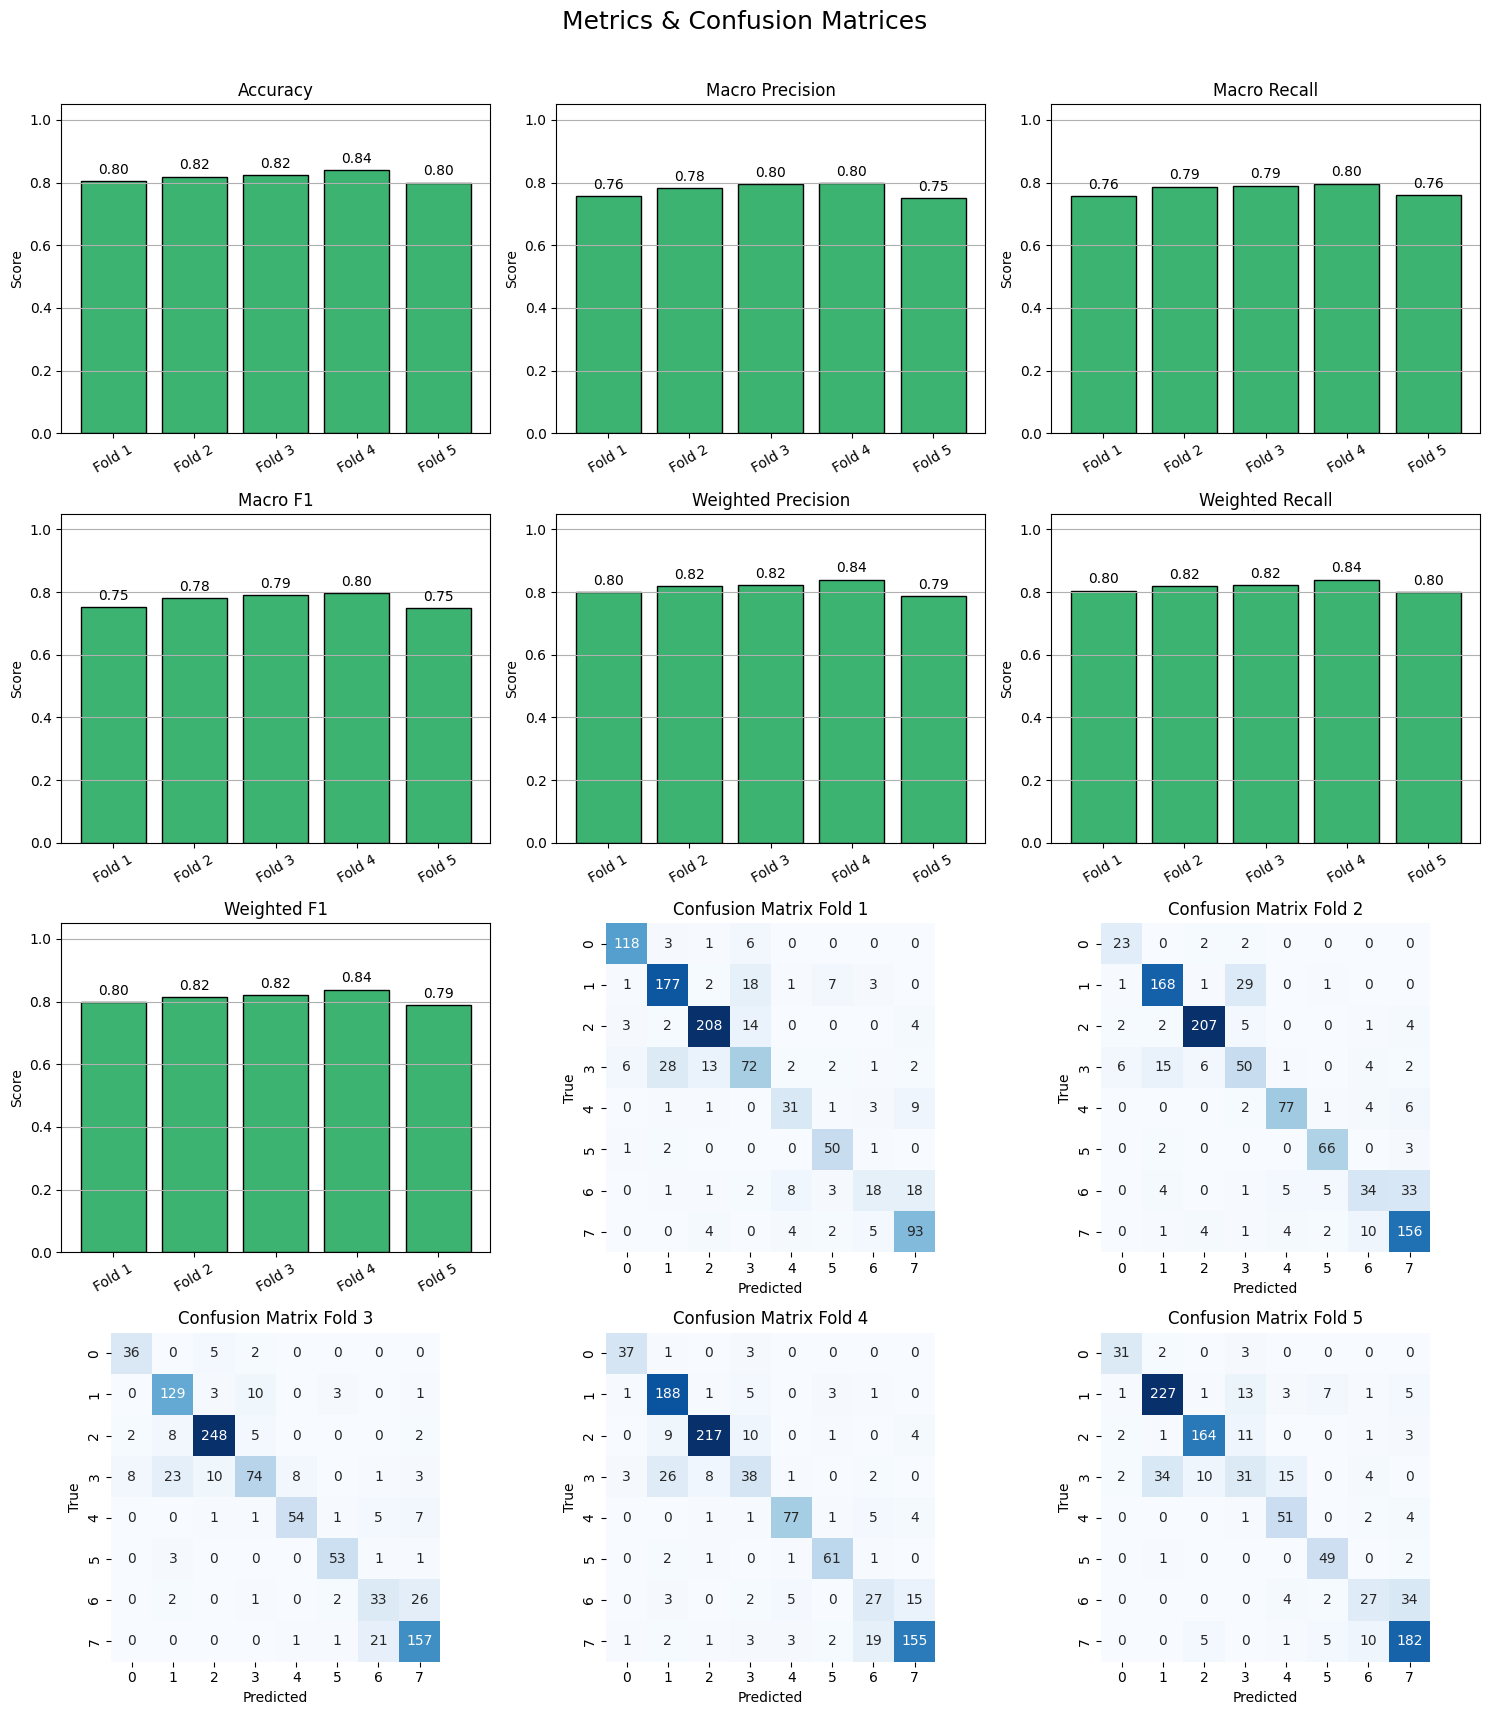

In [13]:
metrics = {
    'Accuracy': best_accs,
    'Macro Precision': best_macro_pres,
    'Macro Recall': best_macro_rec,
    'Macro F1': best_macro_f1,
    'Weighted Precision': best_weighted_pres,
    'Weighted Recall': best_weighted_rec,
    'Weighted F1': best_weighted_f1,
}

plot_metrics_and_heatmaps(metrics, best_cms)

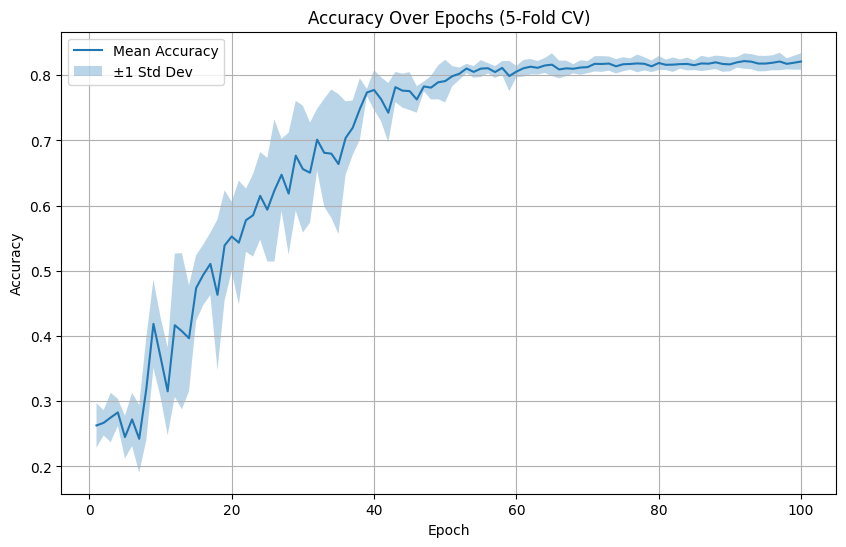

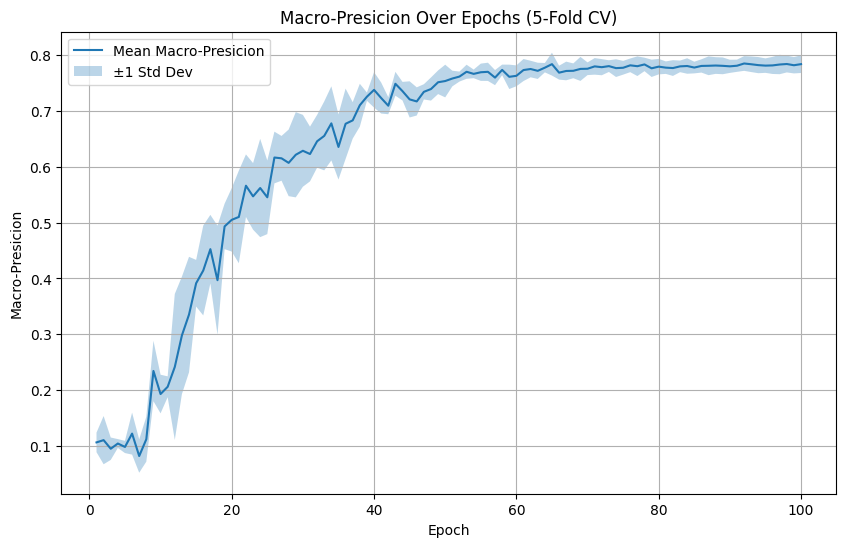

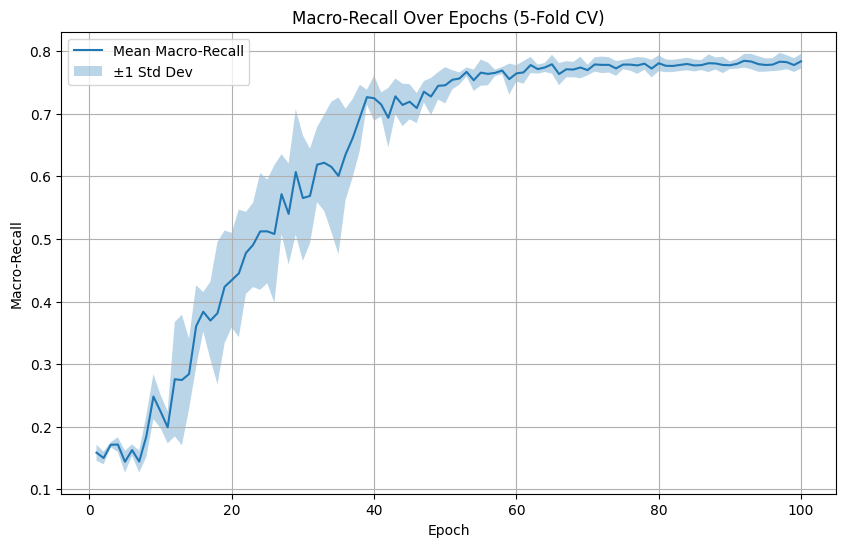

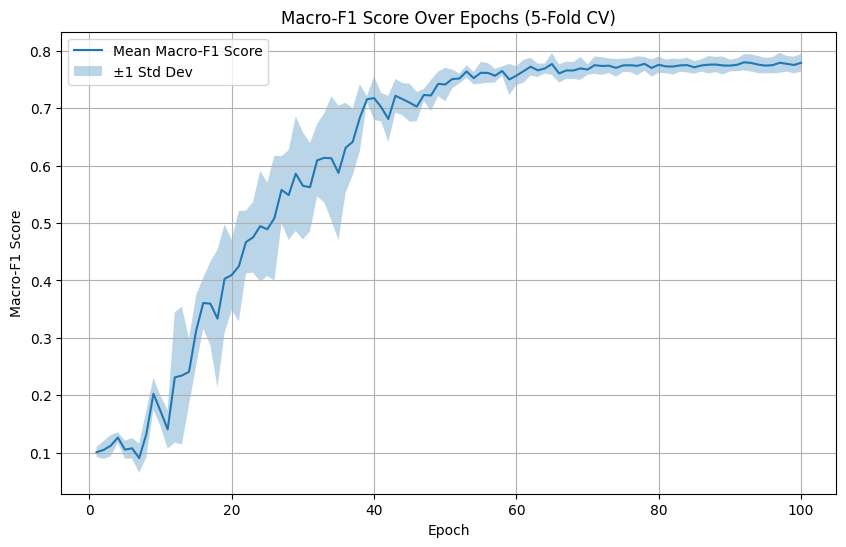

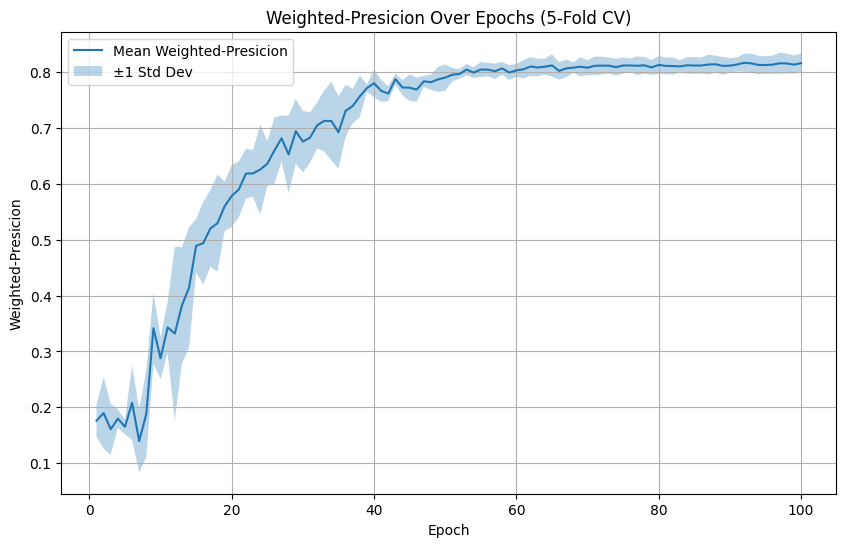

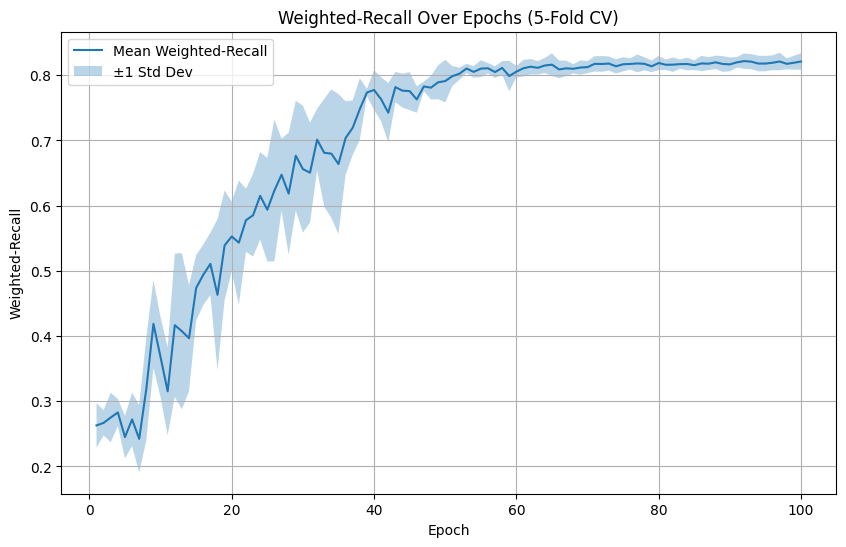

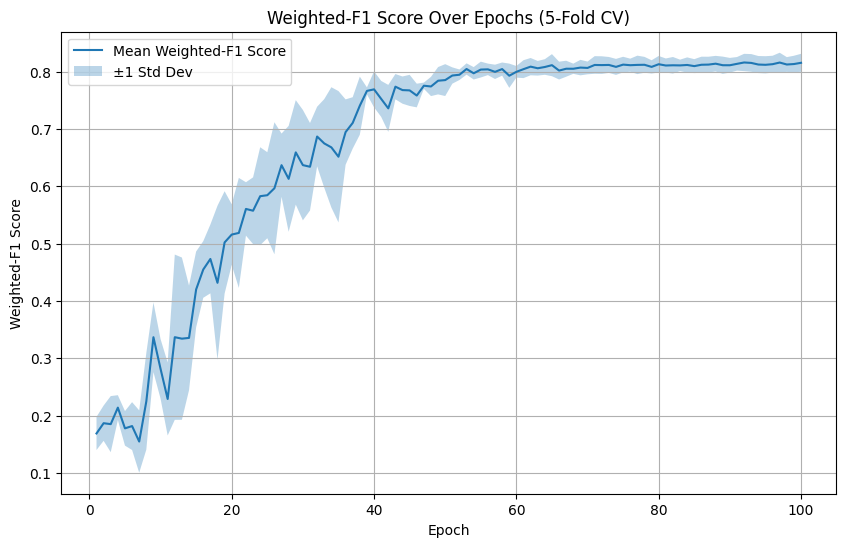

In [14]:
plot_metrics_shaded(per_phase_metric=per_phase_accs, y_label="Accuracy", title="Accuracy Over Epochs (5-Fold CV)", save_path="figures/accuracy")
plot_metrics_shaded(per_phase_metric=per_phase_macro_pres, y_label="Macro-Presicion", title="Macro-Presicion Over Epochs (5-Fold CV)", save_path="figures/macro_pres")
plot_metrics_shaded(per_phase_metric=per_phase_macro_rec, y_label="Macro-Recall", title="Macro-Recall Over Epochs (5-Fold CV)", save_path="figures/macro_recall")
plot_metrics_shaded(per_phase_metric=per_phase_macro_f1, y_label="Macro-F1 Score", title="Macro-F1 Score Over Epochs (5-Fold CV)", save_path="figures/macro_f1")
plot_metrics_shaded(per_phase_metric=per_phase_weighted_pres, y_label="Weighted-Presicion", title="Weighted-Presicion Over Epochs (5-Fold CV)", save_path="figures/weighted_pres")
plot_metrics_shaded(per_phase_metric=per_phase_weighted_rec, y_label="Weighted-Recall", title="Weighted-Recall Over Epochs (5-Fold CV)", save_path="figures/weighted_recall")
plot_metrics_shaded(per_phase_metric=per_phase_weighted_f1, y_label="Weighted-F1 Score", title="Weighted-F1 Score Over Epochs (5-Fold CV)", save_path="figures/weighted_f1")